# Exploratory Data Analysis, plotting receiver operating characteristic curves for different classifiers on a task.

#### Step 1: Initialise global variables

##### In order to streamline the pipeline there are several data variables as well as libraries that we will work with over multiple instances, therefore, it is best to isolate them and declare them globally at the start of the file for ease of access. This will prevent us from needing to declare the variables again late ron in the code however changes made here will require the code box to be ran again to ensure the changes get assed down the pipeline.

In [152]:
# Authors: Jack Eaton Kilgallen, Michelle Collins, Bogdan Dumitru
# Importing necessary libraries
import mne
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import preprocessing, metrics 
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.decomposition import PCA


# Setting the logging level
mne.set_log_level('CRITICAL')

raw_folder_loc = r"C:/Users/Bogdan/Documents/College/4th Year/FYP/EEG_data_Analysis/Raw_Data/"

cleaned_folder_loc = r"C:/Users/Bogdan/Documents/College/4th Year/FYP/EEG_data_Analysis/Cleaned_Data/"

csv_folder_loc = r"C:/Users\Bogdan\Documents/College/4th Year/FYP/EEG_data_Analysis/CSV_Data/"


# Select which subjects, trials and tasks you wish to process
subjects = ["12","13","14","15","16","17","18","19","20","21","22","24","25","26","28","29","30","31","32","33","34","52","53","54","55","56","57","59","60","61"]
#subjects = ["27"]

trials = ["1","2"]

tasks = ["VPA"]

#### Step 2: Renaming
##### The first step towards handling the data is renaming it to ensure anonimity of the patients and the removal of bias, here this python script written by Michelle Collins takes in the original raw data files and relabels them removing the name and adding in a designated number and only keeping the experiment type, further development of this code is difficult as naming convention plays a large role in how the data is processed, errors will occur when ran and manual renaming will have to occur for those cases however this code helps speed up the overall process instead of needing to rename every singe file manually.

In [153]:
# Main function
def rename_raw_data():

    # Nested for loop used to iterate withing the subject folder of the raw folder
    for folder in os.listdir(raw_folder_loc):
        for file in os.listdir(raw_folder_loc + folder):
            
            # Identify the subject from the folder name (the patient number)
            subject = folder
            
            # Check if the file has already been renamed and if so proceed
            if "_1_SG".lower() in file.lower() or \
            "_1_VS".lower() in file.lower() or \
            "_1_VPA".lower() in file.lower() or \
            "_2_SG".lower() in file.lower() or \
            "_2_VS".lower() in file.lower() or \
            "_2_VPA".lower() in file.lower():
                print("File " + file + " already exists")
                continue
            if ".bdf".lower() not in file.lower():
                continue
            
            # Depending on whether or not the string "Exp2b" is in the original name, 
            # determines whether the task will be labeled as the first or second trial
            if "Exp2b".lower() in file.lower():
                trial = "2"
            else:
                trial = "1"
                
            # Identify which task we are relabelling and set the task var accordingly
            if " VPA".lower() in file.lower():
                task = "VPA"
            elif "Spatial".lower() in file.lower():
                task = "SG"
            elif "Visual Search".lower() in file.lower():
                task = "VS"
            elif "finger".lower() in file.lower():
                continue
            elif "eyes".lower() in file.lower():
                continue
            
            # Flag files which may not fall into original naming convention, these will need to be renamed manually
            else:
                print("Did not find task for " + file)
                continue
            
            # Once the file has been correctly identifed the filepath is renamed accordingly and replaces the original
            old_filename = os.path.join(raw_folder_loc, folder, file)
            new_filename = rf"C:/Users/Bogdan/Documents/College/4th Year/FYP/EEG_data_Analysis/Raw_Data/{subject}/{subject}_{trial}_{task}.bdf"
            print("Renaming " + old_filename + " to: " + new_filename )
            os.rename(old_filename, new_filename)
            
# Small indicator for once all the files have been renamed
print("finished renaming")

# Run the renaming function
rename_raw_data()

finished renaming
File 12_1_SG.bdf already exists
File 12_1_VPA.bdf already exists
File 12_1_VS.bdf already exists
File 12_2_SG.bdf already exists
File 12_2_VPA.bdf already exists
File 12_2_VS.bdf already exists


NotADirectoryError: [WinError 267] The directory name is invalid: 'C:/Users/Bogdan/Documents/College/4th Year/FYP/EEG_data_Analysis/Raw_Data/12_1_VPA.eve'

#### Step 3: Preprocessing
##### The next step is to preprocess the data, there are parts of the raw input that need filtering out, such as eye movement, and this next segment of code handles that. We first set the meta data, in other words the channels we use, then we downsample the data and remove the occular noise.

In [154]:
# Function to set the meta data used
def set_meta_data(raw):
    # Define the sensor type of channels.
    raw.set_channel_types({'EXG1': 'misc','EXG2':'misc','EXG3':'misc','EXG4':'misc', 'EXG5':'eog','EXG6': 'eog','EXG7':'misc','EXG8':'misc'})
    try:
        # Try to drop these channels but pass if you cannot
        raw.drop_channels(['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'])
    except:
        pass
    
    # Set EEG channel positions and digitization points.
    raw.set_montage('standard_1020')

# Function to downsample the data
def downsample(raw):
    # Find the current frequency and seet the desired one
    current_sfreq = raw.info['sfreq']
    desired_sfreq = 256
    
    # Generate an obtained frequency form the current and desired ones
    decim = np.round(current_sfreq / desired_sfreq).astype(int)
    obtained_sfreq = current_sfreq / decim
    
    # Generate a lowpass frequency from the obtained one
    lowpass_freq = obtained_sfreq / 3.
    
    # Filter a subset of channels using the lowpass frequency
    raw.filter(l_freq=None, h_freq=lowpass_freq)

# Function to remove ocular noise
def remove_ocular_noise(raw):
    
    # This code estimates independent components from raw, epoched, or evoked objects. 
    # Components can optionally be removed i order to repair an artefact before the signal is reconstructed.
    ica = mne.preprocessing.ICA(n_components=0.95, random_state=97)
    
    # Run the decomposition on the raw data
    ica.fit(raw)
    
    # Create a var for excluding components
    ica.exclude = []
    
    # Detect EOG related components using correlation.
    eog_indices, eog_scores = ica.find_bads_eog(raw)
    
    # Exclude those components
    ica.exclude = eog_indices
    
    # Apply the changes to the raw data
    ica.apply(raw)

# Function to preprocess the raw data
def preprocessing(raw):
    
    # Run the previous two functions
    set_meta_data(raw)
    downsample(raw)
    
    # Filter the channels
    raw.filter(l_freq=0.5, h_freq=None)
    
    # Notch filter for the 50Hz frequency
    raw.notch_filter(freqs=[50])
    
    # Try to remove ocular noise
    try:
        remove_ocular_noise(raw)
    except:
        pass
    
    # Return the final preprocessed raw data
    return raw


#### Step 4: Repair event data
##### The next bit of code, written by Jack Eaton Kilgallen, handles the repairing of certain task trials of patients which may of ended up corrupt or faulty by one means or another, it is crucial to repair this data as we have very little data to work with in the first place and we want to make sure the data we use is accurate.

In [155]:
# Function to repair the event data
def repair_event_data(subject, trial, task, raw):
           
    # Read in files.
    file_name = "{}_{}_{}.bdf".format(subject, trial, task)
    file_loc = os.path.join(raw_folder_loc, str(subject), file_name)
    raw = mne.io.read_raw_bdf(file_loc, preload=True)

    # Find and process events.
    event_file_name = "{}_{} {} Corrected Event File.evt".format(trial, subject, task)
    event_file_loc = os.path.join(raw_folder_loc, str(subject), event_file_name)
    events_as_df = pd.read_csv(event_file_loc, delimiter="\t", index_col = False)   
    events_as_df = events_as_df.drop(events_as_df.columns[3], axis=1).drop([1])
    events_as_df = events_as_df[events_as_df['TriNo'] != '-']
    events_as_df['TriNo'] = pd.to_numeric(events_as_df['TriNo'])
    events_as_df['Code'] = events_as_df['Code'].fillna(0)
    events_as_df['Tmu         '] = events_as_df['Tmu         '] / 1953.003030082584
    event_file_name = "{}_{}_{}.eve".format(subject, trial, task)
    event_file_loc = os.path.join(raw_folder_loc, event_file_name)
    np.savetxt(event_file_loc, events_as_df.values, fmt = '%d', delimiter='\t')

    # Repair and clean the raw data
    events = mne.read_events(event_file_loc)
    for x in range(len(events)):
        if events[x][2] > 1 and events[x][2] < 10:
            events[x][2] -= 2
    raw.add_events(events, stim_channel='Status', replace=True)
    repaired_file_name = "{}_{}_{}_(Cleaned).fif".format(subject, trial, task)
    repaired_file_loc = os.path.join(cleaned_folder_loc, str(subject), repaired_file_name)
    raw.save(repaired_file_loc, overwrite=True)
    
    return raw

#### Event data processing

In [156]:
# Function to relabel VPA events
def relabel_VPA_events(events):
    
    for x in range(len(events) - 1):
        # F/C/C
        if events[x][2] == 4 and events[x+1][2] == 10:
            events[x][2] = 12
        # F/C/I
        elif events[x][2] == 4 and events[x+1][2] == 11:
            events[x][2] = 13
        # F/I/C
        elif events[x][2] == 5 and events[x+1][2] == 10:
            events[x][2] = 14
        # F/I/I
        elif events[x][2] == 5 and events[x+1][2] == 11:
            events[x][2] = 15
        # T/C/C
        elif events[x][2] == 6 and events[x+1][2] == 10:
            events[x][2] = 16
        # T/C/I
        elif events[x][2] == 6 and events[x+1][2] == 11:
            events[x][2] = 17
        # T/I/C
        elif events[x][2] == 7 and events[x+1][2] == 10:
            events[x][2] = 18
        # T/I/I
        elif events[x][2] == 7 and events[x+1][2] == 11:
            events[x][2] = 19

# Function to relabel VS events
def relabel_VS_events(events):
    
    for x in range(len(events) - 1):
        # F LEFT/C
        if events[x][2] == 1 and events[x+1][2] == 10:
            events[x][2] = 12
        # F LEFT/I
        elif events[x][2] == 1 and events[x+1][2] == 11:
            events[x][2] = 13
        # LEFT/C
        elif events[x][2] == 2 and events[x+1][2] == 10:
            events[x][2] = 14
        # LEFT/I
        elif events[x][2] == 2 and events[x+1][2] == 11:
            events[x][2] = 15
        # RIGHT/C
        elif events[x][2] == 3 and events[x+1][2] == 10:
            events[x][2] = 16
        # RIGHT/I
        elif events[x][2] == 3 and events[x+1][2] == 11:
            events[x][2] = 17
        # F RIGHT/C
        elif events[x][2] == 4 and events[x+1][2] == 10:
            events[x][2] = 18
        # F RIGHT/I
        elif events[x][2] == 4 and events[x+1][2] == 11:
            events[x][2] = 19

# Function to relabel SG events
def relabel_SG_events(events):
    
    for x in range(len(events) - 1):
        # NRSL/C
        if events[x][2] == 1 and events[x+1][2] == 10:
            events[x][2] = 12
        # NRSL/I
        elif events[x][2] == 1 and events[x+1][2] == 11:
            events[x][2] = 13
        # RSL/C
        elif events[x][2] == 2 or events[x][2] == 3 or events[x][2] == 4 and events[x+1][2] == 10:
            events[x][2] = 14
        # RSL/I
        elif events[x][2] == 2 or events[x][2] == 3 or events[x][2] == 4 and events[x+1][2] == 11:
            events[x][2] = 15
        # NRNL/C
        elif events[x][2] == 5 and events[x+1][2] == 10:
            events[x][2] = 16
        # NRNL/I
        elif events[x][2] == 5 and events[x+1][2] == 11:
            events[x][2] = 17
        # RNL/C
        elif events[x][2] == 6 or events[x][2] == 7 or events[x][2] == 8 and events[x+1][2] == 10:
            events[x][2] = 18
        # RNL/I
        elif events[x][2] == 6 or events[x][2] == 7 or events[x][2] == 8 and events[x+1][2] == 11:
            events[x][2] = 19

# Function to utilise relabelling functions
def event_data_processing(raw, task):
    
    events = mne.find_events(raw, stim_channel='Status')
    
    if task == "VPA":
        relabel_VPA_events(events)
    elif task == "VS":
        relabel_VS_events(events)
    elif task == "SG":
        relabel_SG_events(events)
        
    raw.add_events(events, stim_channel='Status', replace=True)
    
    return raw

for subject in subjects:
    for trial in trials:
        for task in tasks:
            
            print("Now pipelining subject: " + subject + ", trial: " + trial + ", task: " + task)
            file_name = "{}_{}_{}.bdf".format(subject, trial, task)
            file_loc = os.path.join(raw_folder_loc, subject, file_name)
            
            raw = mne.io.read_raw_bdf(file_loc, preload=True)
            raw = preprocessing(raw)
            
            # Try to repair data
            try:
                raw = repair_event_data(subject, trial, task, raw)
            except FileNotFoundError as e:
                #print(e)
                pass
                
            raw = event_data_processing(raw, task)
            file_name_cleaned = "{}_{}_{}_(Cleaned).fif".format(subject, trial, task)
            file_loc = os.path.join(cleaned_folder_loc, subject, file_name_cleaned)
            raw.save(file_loc, overwrite=True)
            print("Cleaned file " + file_name_cleaned + " saved")


Now pipelining subject: 12, trial: 1, task: VPA
Cleaned file 12_1_VPA_(Cleaned).fif saved
Now pipelining subject: 12, trial: 2, task: VPA
Cleaned file 12_2_VPA_(Cleaned).fif saved
Now pipelining subject: 13, trial: 1, task: VPA


C:\Users\Bogdan\AppData\Local\Temp\ipykernel_12476\3162827680.py:12: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  events_as_df = pd.read_csv(event_file_loc, delimiter="\t", index_col = False)


Cleaned file 13_1_VPA_(Cleaned).fif saved
Now pipelining subject: 13, trial: 2, task: VPA
Cleaned file 13_2_VPA_(Cleaned).fif saved
Now pipelining subject: 14, trial: 1, task: VPA
Cleaned file 14_1_VPA_(Cleaned).fif saved
Now pipelining subject: 14, trial: 2, task: VPA
Cleaned file 14_2_VPA_(Cleaned).fif saved
Now pipelining subject: 15, trial: 1, task: VPA


C:\Users\Bogdan\AppData\Local\Temp\ipykernel_12476\3162827680.py:12: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  events_as_df = pd.read_csv(event_file_loc, delimiter="\t", index_col = False)


Cleaned file 15_1_VPA_(Cleaned).fif saved
Now pipelining subject: 15, trial: 2, task: VPA
Cleaned file 15_2_VPA_(Cleaned).fif saved
Now pipelining subject: 16, trial: 1, task: VPA


C:\Users\Bogdan\AppData\Local\Temp\ipykernel_12476\3162827680.py:12: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  events_as_df = pd.read_csv(event_file_loc, delimiter="\t", index_col = False)


Cleaned file 16_1_VPA_(Cleaned).fif saved
Now pipelining subject: 16, trial: 2, task: VPA
Cleaned file 16_2_VPA_(Cleaned).fif saved
Now pipelining subject: 17, trial: 1, task: VPA
Cleaned file 17_1_VPA_(Cleaned).fif saved
Now pipelining subject: 17, trial: 2, task: VPA
Cleaned file 17_2_VPA_(Cleaned).fif saved
Now pipelining subject: 18, trial: 1, task: VPA
Cleaned file 18_1_VPA_(Cleaned).fif saved
Now pipelining subject: 18, trial: 2, task: VPA
Cleaned file 18_2_VPA_(Cleaned).fif saved
Now pipelining subject: 19, trial: 1, task: VPA
Cleaned file 19_1_VPA_(Cleaned).fif saved
Now pipelining subject: 19, trial: 2, task: VPA
Cleaned file 19_2_VPA_(Cleaned).fif saved
Now pipelining subject: 20, trial: 1, task: VPA
Cleaned file 20_1_VPA_(Cleaned).fif saved
Now pipelining subject: 20, trial: 2, task: VPA
Cleaned file 20_2_VPA_(Cleaned).fif saved
Now pipelining subject: 21, trial: 1, task: VPA
Cleaned file 21_1_VPA_(Cleaned).fif saved
Now pipelining subject: 21, trial: 2, task: VPA
Cleaned fi

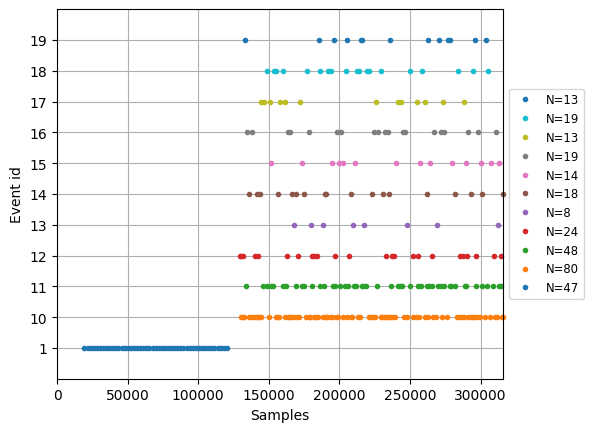

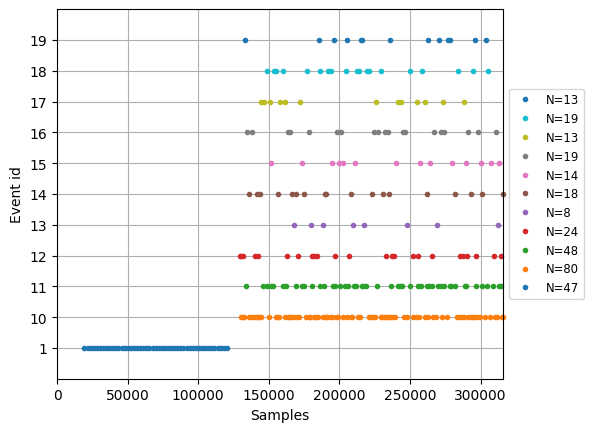

In [157]:
#debugging code to make sure the files have been cleaned correctly
raw_fif = mne.io.read_raw_fif(rf'C:\Users\Bogdan\Documents\College\4th Year\FYP\EEG_data_Analysis\Cleaned_Data\12\12_1_VPA_(Cleaned).fif')
events = mne.find_events(raw_fif)
mne.viz.plot_events(events)

#### Generating evoked responses

In [161]:
# The following variables should contain the location of the EEG files, 
# as well as the subjects, and trials that you wish to get evoked responses for.
subjects = ["12","13","14","15","16","17","18","19","20","21","22","24","25","26","28","29","30","31","32","33","34","52","53","54","55","56","57","59","60","61"]
trials = ["1","2"]

# The task for evoked responses to be estimated for, as well as the appropriate window should be provided.
task = "VPA"
window = [0.2, 0.4]

for subject in subjects:
    for trial in trials:
        
        file_name = "{}_{}_{}_(cleaned).fif".format(subject, trial, task)
        file_loc = os.path.join(cleaned_folder_loc, subject, file_name)
        raw = mne.io.read_raw_fif(file_loc, preload=True)
        events = mne.find_events(raw, stim_channel='Status')
        
        # If downsampling frequency is changed decim will need to change alse.
        # Decim is the integer result of dividing original frequency by downsampled frequency.
        event_dict = {'false/congruent/correct': 12, 'false/congruent/incorrect': 13,
              'false/incongruent/correct': 14, 'false/incongruent/incorrect': 15,
              'true/congruent/correct': 16, 'true/congruent/incorrect': 17,
              'true/incongruent/correct': 18, 'true/incongruent/incorrect': 19}
        
        epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=window[0], tmax=window[1], baseline = None, preload=True, on_missing='ignore', decim=4)

        # Generate evoked responses for correct vs incorrect events
        for item in ['correct','incorrect']:
            item_epochs = epochs[item]
            evoked_response = item_epochs.average()
            export_name = "{}_{}_{}_{}.csv".format(subject, trial, task, '_'.join(item.split('/')))
            export_loc = os.path.join(csv_folder_loc, str(subject), export_name)
            evoked_response.to_data_frame().to_csv(export_loc)

#### Main function
##### This is the main body of the pipeline where all previous segments get called and execute their processes.

In [163]:
# The following variables should contain the location of the EEG files, 
# as well as the subjects, trials, and tasks that are to be used in classification.
folder_loc = rf"C:\Users\Bogdan\Documents\College\4th Year\FYP\EEG_data_Analysis\CSV_Data"
subjects = ["12","13"]
trials = ["1","2"]
tasks = ["VPA"]
task_categories = {"VPA": ["correct"]}

df = pd.DataFrame(columns=['Subject', 'Trial', 'Task', 'Category', 'Group','time', 
                           'Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
                           'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6',
                           'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'])

def leave_one_out_f1(x, y):
    clf = SVC(kernel='linear')
    loo = LeaveOneOut()
    loo.get_n_splits(x)
    y_pred = []
    for train_index, test_index in loo.split(x):
        clf.fit(x[train_index], y[train_index])
        y_pred.append(*clf.predict(x[test_index]))
    return metrics.f1_score(y, y_pred)
    
for subject in subjects:
    for trial in trials:
        for task in tasks:
            for category in task_categories[task]:
                file_name = "{}_{}_{}_{}.csv".format(subject, trial, task, category)
                file_loc = os.path.join(folder_loc, subject, file_name)
                tmp = pd.read_csv(file_loc, index_col=0)
                tmp['Subject'] = subject
                tmp['Trial'] = trial 
                tmp['Task'] = task
                tmp['Category'] = category
                if int(subject) <50:
                    tmp['Group'] = 0
                else:
                    tmp['Group'] = 1
                # If downsampling frequency is changed, samples will need to be changed also
                samples = 256
                if len(tmp) > samples - 1:
                    tmp = tmp.truncate(after=samples - 1)
                df = df.append(tmp)

df['GFP'] = df.loc[:,'Fp1':'Cz'].mean(axis=1)

x = []
y = []
for subject in subjects:
    tmp = df[df['Subject'] == subject]['GFP']
    x.append(tmp)
    y.append(0 if int(subject) < 50 else 1)
x = np.array(x)
y = np.array(y)

print('GFP:', leave_one_out_f1(x,y))

channels = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
                           'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6',
                           'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']

for channel in channels:
    x = []
    for subject in subjects:
        tmp = df[df['Subject'] == subject][channel]
        x.append(tmp)
    x = np.array(x)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    x = np.array(x_scaled)
    x = [item for subject in x for item in subject]
    df[channel] = x

scores = []
for channel in channels:
    x = []
    y = []
    for subject in subjects:
        tmp = df[df['Subject'] == subject][channel]
        x.append(tmp)
        y.append(0 if int(subject) < 23 else 1)
    x = np.array(x)
    y = np.array(y)

    f1 = leave_one_out_f1(x,y)
    print(channel, f1)

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_12476\3366028796.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp)
C:\Users\Bogdan\AppData\Local\Temp\ipykernel_12476\3366028796.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp)
C:\Users\Bogdan\AppData\Local\Temp\ipykernel_12476\3366028796.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp)
C:\Users\Bogdan\AppData\Local\Temp\ipykernel_12476\3366028796.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp)
C:\Users\Bogdan\AppData\Local\Temp\ipykernel_12476\3366028796.py:53: VisibleDeprecationWarning: Creating

ValueError: setting an array element with a sequence.